### MNIST CNN

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')

#### Data

In [2]:
path = untar_data(URLs.MNIST)
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [0]:
il = ImageList.from_folder(path, convert_mode='L') # L means grayscale

In [0]:
defaults.cmap='binary' # show as grayscale

In [6]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

In [4]:
il.items[0] # shows the item

PosixPath('/root/.fastai/data/mnist_png/training/6/43115.png')

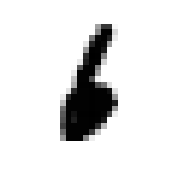

In [7]:
il[0].show() # actual image object

In [0]:
sd = il.split_by_folder(train='training', valid='testing')

In [9]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
ll = sd.label_from_folder()

In [11]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x,y = ll.train[0]

6 torch.Size([1, 28, 28])


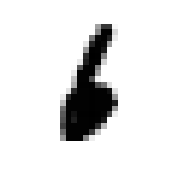

In [13]:
x.show()
print(y,x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], []) # empty set is for validation set; no transforms applied

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]

6 torch.Size([1, 28, 28])


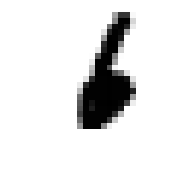

In [19]:
x.show()
print(y,x.shape)

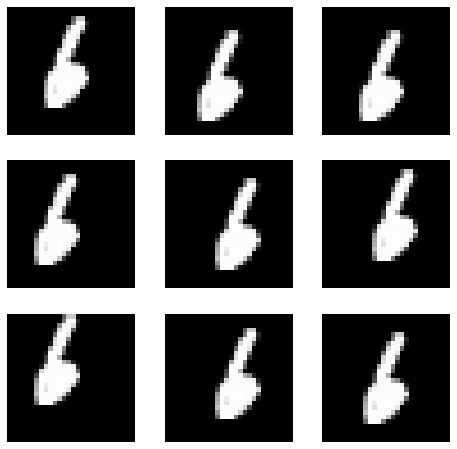

In [20]:
def _plot(i,j,ax): 
  data.train_ds[0][0].show(ax, cmap='gray')

plot_multi(_plot, 3, 3, figsize=(8,8)) # check how many transforms applied on a single image

In [21]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

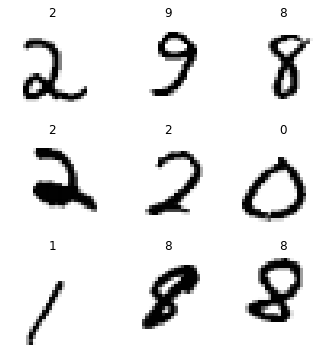

In [22]:
data.show_batch(rows=3, figsize=(5,5))

#### Basic CNN with batchnorm

In [0]:
def conv(ni,nf): 
  return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [0]:
model = nn.Sequential(
    conv(1, 8), # 14 (28x28 image after 2 strides 14x14)
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [26]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [0]:
xb = xb.cuda()

In [28]:
model(xb).shape

torch.Size([128, 10])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


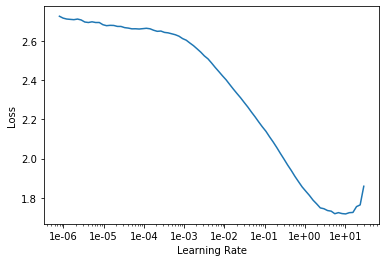

In [29]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.225862,0.309366,0.902800,00:35
1,0.149398,0.095591,0.970900,00:35
2,0.078262,0.042775,0.986500,00:35


#### Refactor

In [0]:
def conv2(ni,nf): 
  return conv_layer(ni,nf,stride=2) # conv_layer does Conv2d, BatchNorm2d, Relu

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [34]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.235594,0.209360,0.934900,00:34
1,0.178052,0.150873,0.953100,00:34
2,0.167448,0.176574,0.941600,00:34
3,0.144725,0.098927,0.969100,00:34
4,0.122296,0.082506,0.974700,00:34
5,0.102341,0.057682,0.980500,00:35
6,0.095492,0.060519,0.981400,00:35
7,0.061914,0.039361,0.987200,00:35
8,0.049622,0.030149,0.989400,00:34
9,0.051522,0.029259,0.990000,00:35


#### Resnet

Accuracy increase we can make NN more deep by adding stride 1 Conv2D after every stirde 2 Conv2D but there is a problem which results in low results than the architecture with stride 2 Conv2D. 

***Resnet:***
To avoid we can do is identity addition.

Insted of O = C2(C1(X)) use <u>**`O = X + C2(C1(X))`** </u>

***Densenet***: To avoid we can do is identity concat.

Insted of O = C2(C1(X)) use <u>**`O = Concat(X, C2(C1(X)))`** </u>

DenseNet are more memory intensive as they store the first layer inputs down the lane but they have less parameters compared to ResNet. 

To reduce the memory we can apply normal conv from time to time.

`DenseNets work well on small datasets compared to ResNets.`

`DenseNets work well for Segmentation as they carry the original inputs.`

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): 
      return x + self.conv2(self.conv1(x))

In [37]:
help(res_block) # refractor of above ResBlock

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): 
  return nn.Sequential(conv2(ni, nf), res_block(nf)) # more refractor above model

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


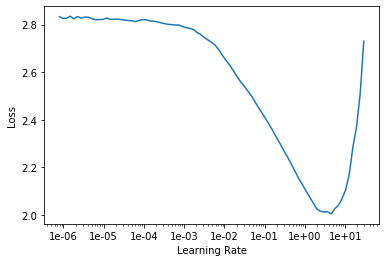

In [42]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.195299,0.120089,0.965700,00:40
1,0.125480,0.219708,0.930200,00:41
2,0.102345,0.065392,0.978900,00:41
3,0.085402,0.085493,0.970600,00:41
4,0.075780,0.203686,0.935300,00:41
5,0.060468,0.061672,0.981900,00:40
6,0.055721,0.042928,0.986100,00:40
7,0.045500,0.028068,0.991300,00:40
8,0.036222,0.020996,0.992900,00:41
9,0.027231,0.016391,0.994100,00:40


In [44]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________